In [2675]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import statsmodels.api as sm 
from sklearn.linear_model import Lasso
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

## Load in all natural gas futures price data

In [2676]:
intraday_prices = pd.read_csv('/Users/masonwasserman/Desktop/Senior Thesis/Data/bins1.csv.gz', compression='gzip')

# Convert to datetime
intraday_prices['timeUTC'] = pd.to_datetime(intraday_prices['timeUTC'])
intraday_prices['timeNY'] = pd.to_datetime(intraday_prices['timeNY'])
intraday_prices['date'] = pd.to_datetime(intraday_prices['date'])
intraday_prices['time'] = intraday_prices['timeUTC'].apply(lambda x: x.time())

daily_prices = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Daily Natural Gas Futures Prices.csv",
                               header = 2)
# Convert to datetime
daily_prices["Date"] = pd.to_datetime(daily_prices["Date"], errors='ignore', format = "%b %d, %Y")

## Clean intraday price data

In [1651]:
clean_intraday = intraday_prices.copy()
for d in intraday_prices['date'].unique():
    daily_df = intraday_prices[intraday_prices['date'] == d]
    top_sym = daily_df.groupby('sym')['v'].sum().nlargest(1).index[0]
    drop_rows = intraday_prices[(intraday_prices['sym'] != top_sym) & (intraday_prices['date'] == d)].index
    clean_intraday = clean_intraday.drop(drop_rows)
    
clean_intraday['midpoint'] = (clean_intraday['bid'] + clean_intraday['ask']) / 2
clean_intraday['timeUTC'] = pd.to_datetime(clean_intraday['timeUTC'])

## Load in weather forecast data

In [11]:
# Read in data of historical weather forecast of all 9 cities
weather_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Forecast Data/Total Forecast Data.csv")
# Reformat date strings in weather_df
weather_df['forecast dt iso'] = pd.to_datetime(weather_df['forecast dt iso'].str[:-10])
weather_df['slice dt iso'] = pd.to_datetime(weather_df['slice dt iso'].str[:-10])
weather_df['MM-DD-HH'] = weather_df['slice dt iso'].dt.strftime('%m-%d-%H')
weather_df['temperature (F)'] = (weather_df['temperature'] * 1.8) + 32
weather_df['temperature (K)'] = weather_df['temperature'] + 273.15
weather_df['Forecasted DD'] = abs(weather_df['temperature (F)'] - 65)
weather_df["forecast window"] = weather_df['slice dt unixtime'] - weather_df['forecast dt unixtime']

## Number of forecasts for each city
N = 2103764

# Spliting up data based on city and exporting as csv

Chicago_df = weather_df.iloc[0:N]

Dallas_df = weather_df.iloc[N:2*N]

New_York_df = weather_df.iloc[2*N:3*N]

Atlanta_df = weather_df.iloc[3*N:4*N]

Miami_df = weather_df.iloc[4*N:5*N]

Denver_df = weather_df.iloc[5*N:6*N]

Los_Angeles_df = weather_df.iloc[6*N:7*N]

Seattle_df = weather_df.iloc[7*N:8*N]

Minneapolis_df = weather_df.iloc[8*N:]

## Load in actual weather data

In [634]:
# Chicago
actual_Chicago_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Chicago_41_878114_-87_629798_623cd840b572d400076bdb02.csv")
actual_Chicago_df['dt_iso'] = pd.to_datetime(actual_Chicago_df['dt_iso'].str[:-10])
actual_Chicago_df['MM-DD-HH'] = actual_Chicago_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Chicago_df['temp (F)'] = (actual_Chicago_df['temp'] * 1.8) + 32
actual_Chicago_df['Degree Days'] = abs(actual_Chicago_df['temp (F)'] - 65)
Chicago_hist_DD_dict = actual_Chicago_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Chicago_act_DD_dict = actual_Chicago_df.set_index('dt_iso').to_dict()['Degree Days']
Chicago_hist_temp_dict = actual_Chicago_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Chicago_act_temp_dict = actual_Chicago_df.set_index('dt_iso').to_dict()['temp (F)']

# Dallas
actual_Dallas_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Dallas_32_776664_-96_796988_623cd840b572d400076bdb02.csv")
actual_Dallas_df['dt_iso'] = pd.to_datetime(actual_Dallas_df['dt_iso'].str[:-10])
actual_Dallas_df['MM-DD-HH'] = actual_Dallas_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Dallas_df['temp (F)'] = (actual_Dallas_df['temp'] * 1.8) + 32
actual_Dallas_df['Degree Days'] = abs(actual_Dallas_df['temp (F)'] - 65)
Dallas_hist_DD_dict = actual_Dallas_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Dallas_act_DD_dict = actual_Dallas_df.set_index('dt_iso').to_dict()['Degree Days']
Dallas_hist_temp_dict = actual_Dallas_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Dallas_act_temp_dict = actual_Dallas_df.set_index('dt_iso').to_dict()['temp (F)']


# New York
actual_New_York_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/New_York_40_712775_-74_005973_623cd840b572d400076bdb02.csv")
actual_New_York_df['dt_iso'] = pd.to_datetime(actual_New_York_df['dt_iso'].str[:-10])
actual_New_York_df['MM-DD-HH'] = actual_New_York_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_New_York_df['temp (F)'] = (actual_New_York_df['temp'] * 1.8) + 32
actual_New_York_df['Degree Days'] = abs(actual_New_York_df['temp (F)'] - 65)
New_York_hist_DD_dict = actual_New_York_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
New_York_act_DD_dict = actual_New_York_df.set_index('dt_iso').to_dict()['Degree Days']
New_York_hist_temp_dict = actual_New_York_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
New_York_act_temp_dict = actual_New_York_df.set_index('dt_iso').to_dict()['temp (F)']

# Atlanta
actual_Atlanta_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Atlanta_33_748995_-84_387982_623cd840b572d400076bdb02.csv")
actual_Atlanta_df['dt_iso'] = pd.to_datetime(actual_Atlanta_df['dt_iso'].str[:-10])
actual_Atlanta_df['MM-DD-HH'] = actual_Atlanta_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Atlanta_df['temp (F)'] = (actual_Atlanta_df['temp'] * 1.8) + 32
actual_Atlanta_df['Degree Days'] = abs(actual_Atlanta_df['temp (F)'] - 65)
Atlanta_hist_DD_dict = actual_Atlanta_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Atlanta_act_DD_dict = actual_Atlanta_df.set_index('dt_iso').to_dict()['Degree Days']
Atlanta_hist_temp_dict = actual_Atlanta_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Atlanta_act_temp_dict = actual_Atlanta_df.set_index('dt_iso').to_dict()['temp (F)']

# Miami
actual_Miami_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Miami_25_76168_-80_19179_623cd840b572d400076bdb02.csv")
actual_Miami_df['dt_iso'] = pd.to_datetime(actual_Miami_df['dt_iso'].str[:-10])
actual_Miami_df['MM-DD-HH'] = actual_Miami_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Miami_df['temp (F)'] = (actual_Miami_df['temp'] * 1.8) + 32
actual_Miami_df['Degree Days'] = abs(actual_Miami_df['temp (F)'] - 65)
Miami_hist_DD_dict = actual_Miami_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Miami_act_DD_dict = actual_Miami_df.set_index('dt_iso').to_dict()['Degree Days']
Miami_hist_temp_dict = actual_Miami_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Miami_act_temp_dict = actual_Miami_df.set_index('dt_iso').to_dict()['temp (F)']

# Denver
actual_Denver_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Denver_39_739236_-104_990251_623cd840b572d400076bdb02.csv")
actual_Denver_df['dt_iso'] = pd.to_datetime(actual_Denver_df['dt_iso'].str[:-10])
actual_Denver_df['MM-DD-HH'] = actual_Denver_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Denver_df['temp (F)'] = (actual_Denver_df['temp'] * 1.8) + 32
actual_Denver_df['Degree Days'] = abs(actual_Denver_df['temp (F)'] - 65)
Denver_hist_DD_dict = actual_Denver_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Denver_act_DD_dict = actual_Denver_df.set_index('dt_iso').to_dict()['Degree Days']
Denver_hist_temp_dict = actual_Denver_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Denver_act_temp_dict = actual_Denver_df.set_index('dt_iso').to_dict()['temp (F)']

# Los Angeles
actual_Los_Angeles_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Los_Angeles_34_052234_-118_243685_623cd840b572d400076bdb02.csv")
actual_Los_Angeles_df['dt_iso'] = pd.to_datetime(actual_Los_Angeles_df['dt_iso'].str[:-10])
actual_Los_Angeles_df['MM-DD-HH'] = actual_Los_Angeles_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Los_Angeles_df['temp (F)'] = (actual_Los_Angeles_df['temp'] * 1.8) + 32
actual_Los_Angeles_df['Degree Days'] = abs(actual_Los_Angeles_df['temp (F)'] - 65)
Los_Angeles_hist_DD_dict = actual_Los_Angeles_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Los_Angeles_act_DD_dict = actual_Los_Angeles_df.set_index('dt_iso').to_dict()['Degree Days']
Los_Angeles_hist_temp_dict = actual_Los_Angeles_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Los_Angeles_act_temp_dict = actual_Los_Angeles_df.set_index('dt_iso').to_dict()['temp (F)']

# Seattle
actual_Seattle_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Seattle_47_606209_-122_332071_623cd840b572d400076bdb02.csv")
actual_Seattle_df['dt_iso'] = pd.to_datetime(actual_Seattle_df['dt_iso'].str[:-10])
actual_Seattle_df['MM-DD-HH'] = actual_Seattle_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Seattle_df['temp (F)'] = (actual_Seattle_df['temp'] * 1.8) + 32
actual_Seattle_df['Degree Days'] = abs(actual_Seattle_df['temp (F)'] - 65)
Seattle_hist_DD_dict = actual_Seattle_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Seattle_act_DD_dict = actual_Seattle_df.set_index('dt_iso').to_dict()['Degree Days']
Seattle_hist_temp_dict = actual_Seattle_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Seattle_act_temp_dict = actual_Seattle_df.set_index('dt_iso').to_dict()['temp (F)']

# Minneapolis
actual_Minneapolis_df = pd.read_csv("/Users/masonwasserman/Desktop/Senior Thesis/Data/Weather Actual Data/Minneapolis_44_977753_-93_265011_623cd840b572d400076bdb02.csv")
actual_Minneapolis_df['dt_iso'] = pd.to_datetime(actual_Minneapolis_df['dt_iso'].str[:-10])
actual_Minneapolis_df['MM-DD-HH'] = actual_Minneapolis_df['dt_iso'].dt.strftime('%m-%d-%H')
actual_Minneapolis_df['temp (F)'] = (actual_Minneapolis_df['temp'] * 1.8) + 32
actual_Minneapolis_df['Degree Days'] = abs(actual_Minneapolis_df['temp (F)'] - 65)
Minneapolis_hist_DD_dict = actual_Minneapolis_df.groupby(['MM-DD-HH'])['Degree Days'].mean().to_dict()
Minneapolis_act_DD_dict = actual_Minneapolis_df.set_index('dt_iso').to_dict()['Degree Days']
Minneapolis_hist_temp_dict = actual_Minneapolis_df.groupby(['MM-DD-HH'])['temp (F)'].mean().to_dict()
Minneapolis_act_temp_dict = actual_Minneapolis_df.set_index('dt_iso').to_dict()['temp (F)']



## Only keep forecasts for 0, 6, 12, 18 UTC

In [680]:
# Clean data. Only keep one forecast per day and forecast outlook increment by 1-day only 
initial_unixtime = 1507334400
periodLength_unix = 60*60*6
final_date = datetime.datetime.strptime('2022-01-30 18:00:00', '%Y-%m-%d %H:%M:%S')

# All 
quart_weather_df = weather_df[(((weather_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((weather_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_weather_df = quart_weather_df[quart_weather_df['slice dt iso'] <= final_date]

# Chicago
quart_Chicago_df = Chicago_df[(((Chicago_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Chicago_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Chicago_df = quart_Chicago_df[quart_Chicago_df['slice dt iso'] <= final_date]
quart_Chicago_df['historical DD'] = quart_Chicago_df['MM-DD-HH'].map(Chicago_hist_DD_dict)
quart_Chicago_df['actual DD'] = quart_Chicago_df['slice dt iso'].map(Chicago_act_DD_dict)
quart_Chicago_df['actual temp (F)'] = quart_Chicago_df['slice dt iso'].map(Chicago_act_temp_dict)
quart_Chicago_df['historical temp (F)'] = quart_Chicago_df['MM-DD-HH'].map(Chicago_hist_temp_dict)
quart_Chicago_df['Chicago Hist DD Error'] = quart_Chicago_df['Forecasted DD'] - quart_Chicago_df['historical DD']
quart_Chicago_df['Chicago Act DD Error'] = quart_Chicago_df['Forecasted DD'] - quart_Chicago_df['actual DD']
quart_Chicago_df['Chicago Act Forecast Error'] = quart_Chicago_df['temperature (F)'] - quart_Chicago_df['actual temp (F)']
quart_Chicago_df['Chicago Hist Forecast Error'] = quart_Chicago_df['temperature (F)'] - quart_Chicago_df['historical temp (F)']

# Dallas
quart_Dallas_df = Dallas_df[(((Dallas_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Dallas_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Dallas_df = quart_Dallas_df[quart_Dallas_df['slice dt iso'] <= final_date]
quart_Dallas_df['historical DD'] = quart_Dallas_df['MM-DD-HH'].map(Dallas_hist_DD_dict)
quart_Dallas_df['actual DD'] = quart_Dallas_df['slice dt iso'].map(Dallas_act_DD_dict)
quart_Dallas_df['actual temp (F)'] = quart_Dallas_df['slice dt iso'].map(Dallas_act_temp_dict)
quart_Dallas_df['historical temp (F)'] = quart_Dallas_df['MM-DD-HH'].map(Dallas_hist_temp_dict)
quart_Dallas_df['Dallas Hist DD Error'] = quart_Dallas_df['Forecasted DD'] - quart_Dallas_df['historical DD']
quart_Dallas_df['Dallas Act DD Error'] = quart_Dallas_df['Forecasted DD'] - quart_Dallas_df['actual DD']
quart_Dallas_df['Dallas Act Forecast Error'] = quart_Dallas_df['temperature (F)'] - quart_Dallas_df['actual temp (F)']
quart_Dallas_df['Dallas Hist Forecast Error'] = quart_Dallas_df['temperature (F)'] - quart_Dallas_df['historical temp (F)']

# New York
quart_New_York_df = New_York_df[(((New_York_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((New_York_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_New_York_df = quart_New_York_df[quart_New_York_df['slice dt iso'] <= final_date]
quart_New_York_df['historical DD'] = quart_New_York_df['MM-DD-HH'].map(New_York_hist_DD_dict)
quart_New_York_df['actual DD'] = quart_New_York_df['slice dt iso'].map(New_York_act_DD_dict)
quart_New_York_df['actual temp (F)'] = quart_New_York_df['slice dt iso'].map(New_York_act_temp_dict)
quart_New_York_df['historical temp (F)'] = quart_New_York_df['MM-DD-HH'].map(New_York_hist_temp_dict)
quart_New_York_df['New York Hist DD Error'] = quart_New_York_df['Forecasted DD'] - quart_New_York_df['historical DD']
quart_New_York_df['New York Act DD Error'] = quart_New_York_df['Forecasted DD'] - quart_New_York_df['actual DD']
quart_New_York_df['New York Act Forecast Error'] = quart_New_York_df['temperature (F)'] - quart_New_York_df['actual temp (F)']
quart_New_York_df['New York Hist Forecast Error'] = quart_New_York_df['temperature (F)'] - quart_New_York_df['historical temp (F)']


# Atlanta
quart_Atlanta_df = Atlanta_df[(((Atlanta_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Atlanta_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Atlanta_df = quart_Atlanta_df[quart_Atlanta_df['slice dt iso'] <= final_date]
quart_Atlanta_df['historical DD'] = quart_Atlanta_df['MM-DD-HH'].map(Atlanta_hist_DD_dict)
quart_Atlanta_df['actual DD'] = quart_Atlanta_df['slice dt iso'].map(Atlanta_act_DD_dict)
quart_Atlanta_df['actual temp (F)'] = quart_Atlanta_df['slice dt iso'].map(Atlanta_act_temp_dict)
quart_Atlanta_df['historical temp (F)'] = quart_Atlanta_df['MM-DD-HH'].map(Atlanta_hist_temp_dict)
quart_Atlanta_df['Atlanta Hist DD Error'] = quart_Atlanta_df['Forecasted DD'] - quart_Atlanta_df['historical DD']
quart_Atlanta_df['Atlanta Act DD Error'] = quart_Atlanta_df['Forecasted DD'] - quart_Atlanta_df['actual DD']
quart_Atlanta_df['Atlanta Act Forecast Error'] = quart_Atlanta_df['temperature (F)'] - quart_Atlanta_df['actual temp (F)']
quart_Atlanta_df['Atlanta Hist Forecast Error'] = quart_Atlanta_df['temperature (F)'] - quart_Atlanta_df['historical temp (F)']


# Denver
quart_Denver_df = Denver_df[(((Denver_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Denver_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Denver_df = quart_Denver_df[quart_Denver_df['slice dt iso'] <= final_date]
quart_Denver_df['historical DD'] = quart_Denver_df['MM-DD-HH'].map(Denver_hist_DD_dict)
quart_Denver_df['actual DD'] = quart_Denver_df['slice dt iso'].map(Denver_act_DD_dict)
quart_Denver_df['actual temp (F)'] = quart_Denver_df['slice dt iso'].map(Denver_act_temp_dict)
quart_Denver_df['historical temp (F)'] = quart_Denver_df['MM-DD-HH'].map(Denver_hist_temp_dict)
quart_Denver_df['Denver Hist DD Error'] = quart_Denver_df['Forecasted DD'] - quart_Denver_df['historical DD']
quart_Denver_df['Denver Act DD Error'] = quart_Denver_df['Forecasted DD'] - quart_Denver_df['actual DD']
quart_Denver_df['Denver Act Forecast Error'] = quart_Denver_df['temperature (F)'] - quart_Denver_df['actual temp (F)']
quart_Denver_df['Denver Hist Forecast Error'] = quart_Denver_df['temperature (F)'] - quart_Denver_df['historical temp (F)']

# Miaimi
quart_Miami_df = Miami_df[(((Miami_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Miami_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Miami_df = quart_Miami_df[quart_Miami_df['slice dt iso'] <= final_date]
quart_Miami_df['historical DD'] = quart_Miami_df['MM-DD-HH'].map(Miami_hist_DD_dict)
quart_Miami_df['actual DD'] = quart_Miami_df['slice dt iso'].map(Miami_act_DD_dict)
quart_Miami_df['actual temp (F)'] = quart_Miami_df['slice dt iso'].map(Miami_act_temp_dict)
quart_Miami_df['historical temp (F)'] = quart_Miami_df['MM-DD-HH'].map(Miami_hist_temp_dict)
quart_Miami_df['Miami Hist DD Error'] = quart_Miami_df['Forecasted DD'] - quart_Miami_df['historical DD']
quart_Miami_df['Miami Act DD Error'] = quart_Miami_df['Forecasted DD'] - quart_Miami_df['actual DD']
quart_Miami_df['Miami Act Forecast Error'] = quart_Miami_df['temperature (F)'] - quart_Miami_df['actual temp (F)']
quart_Miami_df['Miami Hist Forecast Error'] = quart_Miami_df['temperature (F)'] - quart_Miami_df['historical temp (F)']

# Los Angeles
quart_Los_Angeles_df = Los_Angeles_df[(((Los_Angeles_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Los_Angeles_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Los_Angeles_df = quart_Los_Angeles_df[quart_Los_Angeles_df['slice dt iso'] <= final_date]
quart_Los_Angeles_df['historical DD'] = quart_Los_Angeles_df['MM-DD-HH'].map(Los_Angeles_hist_DD_dict)
quart_Los_Angeles_df['actual DD'] = quart_Los_Angeles_df['slice dt iso'].map(Los_Angeles_act_DD_dict)
quart_Los_Angeles_df['actual temp (F)'] = quart_Los_Angeles_df['slice dt iso'].map(Los_Angeles_act_temp_dict)
quart_Los_Angeles_df['historical temp (F)'] = quart_Los_Angeles_df['MM-DD-HH'].map(Los_Angeles_hist_temp_dict)
quart_Los_Angeles_df['Los Angeles Hist DD Error'] = quart_Los_Angeles_df['Forecasted DD'] - quart_Los_Angeles_df['historical DD']
quart_Los_Angeles_df['Los Angeles Act DD Error'] = quart_Los_Angeles_df['Forecasted DD'] - quart_Los_Angeles_df['actual DD']
quart_Los_Angeles_df['Los Angeles Act Forecast Error'] = quart_Los_Angeles_df['temperature (F)'] - quart_Los_Angeles_df['actual temp (F)']
quart_Los_Angeles_df['Los Angeles Hist Forecast Error'] = quart_Los_Angeles_df['temperature (F)'] - quart_Los_Angeles_df['historical temp (F)']

# Seattle
quart_Seattle_df = Seattle_df[(((Seattle_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Seattle_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Seattle_df = quart_Seattle_df[quart_Seattle_df['slice dt iso'] <= final_date]
quart_Seattle_df['historical DD'] = quart_Seattle_df['MM-DD-HH'].map(Seattle_hist_DD_dict)
quart_Seattle_df['actual DD'] = quart_Seattle_df['slice dt iso'].map(Seattle_act_DD_dict)
quart_Seattle_df['actual temp (F)'] = quart_Seattle_df['slice dt iso'].map(Seattle_act_temp_dict)
quart_Seattle_df['historical temp (F)'] = quart_Seattle_df['MM-DD-HH'].map(Seattle_hist_temp_dict)
quart_Seattle_df['Seattle Hist DD Error'] = quart_Seattle_df['Forecasted DD'] - quart_Seattle_df['historical DD']
quart_Seattle_df['Seattle Act DD Error'] = quart_Seattle_df['Forecasted DD'] - quart_Seattle_df['actual DD']
quart_Seattle_df['Seattle Act Forecast Error'] = quart_Seattle_df['temperature (F)'] - quart_Seattle_df['actual temp (F)']
quart_Seattle_df['Seattle Hist Forecast Error'] = quart_Seattle_df['temperature (F)'] - quart_Seattle_df['historical temp (F)']

# Minneapolis
quart_Minneapolis_df = Minneapolis_df[(((Minneapolis_df['forecast dt unixtime'] - initial_unixtime) % periodLength_unix == 0) &
                             ((Minneapolis_df['slice dt unixtime'] - initial_unixtime) % periodLength_unix == 0))]
quart_Minneapolis_df = quart_Minneapolis_df[quart_Minneapolis_df['slice dt iso'] <= final_date]
quart_Minneapolis_df['historical DD'] = quart_Minneapolis_df['MM-DD-HH'].map(Minneapolis_hist_DD_dict)
quart_Minneapolis_df['actual DD'] = quart_Minneapolis_df['slice dt iso'].map(Minneapolis_act_DD_dict)
quart_Minneapolis_df['actual temp (F)'] = quart_Minneapolis_df['slice dt iso'].map(Minneapolis_act_temp_dict)
quart_Minneapolis_df['historical temp (F)'] = quart_Minneapolis_df['MM-DD-HH'].map(Minneapolis_hist_temp_dict)
quart_Minneapolis_df['Minneapolis Hist DD Error'] = quart_Minneapolis_df['Forecasted DD'] - quart_Minneapolis_df['historical DD']
quart_Minneapolis_df['Minneapolis Act DD Error'] = quart_Minneapolis_df['Forecasted DD'] - quart_Minneapolis_df['actual DD']
quart_Minneapolis_df['Minneapolis Act Forecast Error'] = quart_Minneapolis_df['temperature (F)'] - quart_Minneapolis_df['actual temp (F)']
quart_Minneapolis_df['Minneapolis Hist Forecast Error'] = quart_Minneapolis_df['temperature (F)'] - quart_Minneapolis_df['historical temp (F)']


##  Select which intraday prices to use in regression (Forecast Error)

In [1778]:
# Get intraday prices in 6hr intervals at 3, 9, 15, 21 UTC

# Intraday prices in 6hr intervals at 3, 9, 15, 21 UTC
# intraday_6hr = clean_intraday[((clean_intraday['timeUTC'].dt.hour % 6) == 1) &
#                               (clean_intraday['timeUTC'].dt.minute == 0)]

# Only 12 and 18
# intraday_6hr = clean_intraday[((clean_intraday['timeUTC'].dt.hour == 13) | (clean_intraday['timeUTC'].dt.hour == 19))
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 12
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 19)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 18
intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 23)
                              & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 6
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 7)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 0
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 1)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 17:00 - 19:00
# intraday_6hr = clean_intraday[((clean_intraday['timeUTC'].dt.hour == 17) | (clean_intraday['timeUTC'].dt.hour == 19))
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]
# # ## Only 18:00 - 18:30
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 18)]

# Calculate log returns
intraday_6hr['log ret'] = np.log(intraday_6hr['midpoint']) - np.log(intraday_6hr['midpoint'].shift(1))

# Calculate difference is price
intraday_6hr['price diff'] = intraday_6hr['midpoint'] - intraday_6hr['midpoint'].shift(1)

intraday_6hr['Forecast Date'] = intraday_6hr['timeUTC'] - datetime.timedelta(hours=5)
intraday_6hr = intraday_6hr.iloc[1:]
intraday_6hr = intraday_6hr.set_index(['Forecast Date'])

# # Only when doing 17-19
# intraday_6hr = intraday_6hr[intraday_6hr['timeUTC'].dt.hour == 19]


/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/3949347915.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_6hr['log ret'] = np.log(intraday_6hr['midpoint']) - np.log(intraday_6hr['midpoint'].shift(1))
/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/3949347915.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_6hr['price diff'] = intraday_6hr['midpoint'] - intraday_6hr['midpoint'].shift(1)
/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725

In [2393]:
# Select data between Standard Time and Daylight Savings Time
model_prices = clean_intraday.set_index('timeUTC')
# Only EDT
model_prices = model_prices[model_prices.index == model_prices['timeNY'] + datetime.timedelta(hours=4)]

# Only EST
# model_prices = model_prices[model_prices.index == model_prices['timeNY'] + datetime.timedelta(hours=5)]

# Select which forecasts to get prices for


# 00:00 UTC
start0 = datetime.time(hour =3, minute =30)
end0 = datetime.time(hour = 8)
prices_0 = model_prices[(model_prices['time'] == start0) | (model_prices['time'] == end0)]
prices_0['Price Diff'] = prices_0['midpoint'].diff()
prices_0 = prices_0[prices_0['time'] == end0]
prices_0['Forecast Model'] = prices_0.index - datetime.timedelta(hours=8)
prices_0 = prices_0.set_index('Forecast Model')

# 06:00 UTC
start6 = datetime.time(hour =9, minute =30)
end6 = datetime.time(hour = 13)
prices_6 = model_prices[(model_prices['time'] == start6) | (model_prices['time'] == end6)]
prices_6['Price Diff'] = prices_6['midpoint'].diff()
prices_6 = prices_6[prices_6['time'] == end6]
prices_6['Forecast Model'] = prices_6.index - datetime.timedelta(hours =7)
prices_6 = prices_6.set_index('Forecast Model')


# 12:00 UTC
start12 = datetime.time(hour = 15, minute =30)
end12 = datetime.time(hour = 20)
prices_12 = model_prices[(model_prices['time'] == start12) | (model_prices['time'] == end12)]
prices_12['Price Diff'] = prices_12['midpoint'].diff()
prices_12 = prices_12[prices_12['time'] == end12]
prices_12['Forecast Model'] = prices_12.index - datetime.timedelta(hours =8)
prices_12 = prices_12.set_index('Forecast Model')

# 18:00 UTC
start18 = datetime.time(hour = 21, minute =0)
end18 = datetime.time(hour = 1)
prices_18 = model_prices[(model_prices['time'] == start18) | (model_prices['time'] == end18)]
prices_18['Price Diff'] = prices_18['midpoint'].diff()
prices_18 = prices_18[prices_18['time'] == end18][1:]
prices_18['Forecast Model'] = prices_18.index - datetime.timedelta(hours =7)

# Exclude Monday since weekend
prices_18 = prices_18[prices_18.index.weekday != 0]

prices_18 = prices_18.set_index('Forecast Model')

frames = [
        prices_0,
        prices_6,
        prices_12,
        prices_18
        ]
intraday_6hr = pd.concat(frames)
intraday_6hr = intraday_6hr.sort_index()


## Construct Forecast Error Regression

In [2394]:
cols = []
for i in range(10*4):
    t1 = i
    t2 = i+1

    # Chicago
    t1_day = quart_Chicago_df[quart_Chicago_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Chicago_df[quart_Chicago_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Chicago Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())

    # Dallas
    t1_day = quart_Dallas_df[quart_Dallas_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Dallas_df[quart_Dallas_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Dallas Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())
    
    # New York
    t1_day = quart_New_York_df[quart_New_York_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_New_York_df[quart_New_York_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "New York Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())
    
    # Atlanta
    t1_day = quart_Atlanta_df[quart_Atlanta_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Atlanta_df[quart_Atlanta_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Atlanta Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())

    # Denver
    t1_day = quart_Denver_df[quart_Denver_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Denver_df[quart_Denver_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Denver Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())

    # Miami
    t1_day = quart_Miami_df[quart_Miami_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Miami_df[quart_Miami_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Miami Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())

    # Los Angeles
    t1_day = quart_Los_Angeles_df[quart_Los_Angeles_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Los_Angeles_df[quart_Los_Angeles_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Los Angeles Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())

    # Seattle
    t1_day = quart_Seattle_df[quart_Seattle_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Seattle_df[quart_Seattle_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Seattle Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())

    # Minneapolis
    t1_day = quart_Minneapolis_df[quart_Minneapolis_df['forecast window']== t1*periodLength_unix][1:].reset_index() 
    t2_day = quart_Minneapolis_df[quart_Minneapolis_df['forecast window']== t2*periodLength_unix].reset_index()
    diff = t1_day['temperature (F)'] - t2_day['temperature (F)']
    diff = pd.concat([diff, t1_day['forecast dt iso']], axis =1)
    title = "Minneapolis Temp Diff (Day {} - {})".format(t1/4,t2/4)
    diff = diff.rename(columns={"temperature (F)":title})
    diff = diff.set_index('forecast dt iso')
    cols.append(diff.squeeze())
    
combined_forecast_error = pd.concat(cols, axis=1, join='inner')
combined_forecast_error = combined_forecast_error.merge(intraday_6hr[['Price Diff']], how ='inner', left_index=True, right_index=True)


In [2395]:
combined_forecast_error

,Chicago Temp Diff (Day 0.0 - 0.25),Dallas Temp Diff (Day 0.0 - 0.25),New York Temp Diff (Day 0.0 - 0.25),Atlanta Temp Diff (Day 0.0 - 0.25),Denver Temp Diff (Day 0.0 - 0.25),Miami Temp Diff (Day 0.0 - 0.25),Los Angeles Temp Diff (Day 0.0 - 0.25),Seattle Temp Diff (Day 0.0 - 0.25),Minneapolis Temp Diff (Day 0.0 - 0.25),Chicago Temp Diff (Day 0.25 - 0.5),...,Chicago Temp Diff (Day 9.75 - 10.0),Dallas Temp Diff (Day 9.75 - 10.0),New York Temp Diff (Day 9.75 - 10.0),Atlanta Temp Diff (Day 9.75 - 10.0),Denver Temp Diff (Day 9.75 - 10.0),Miami Temp Diff (Day 9.75 - 10.0),Los Angeles Temp Diff (Day 9.75 - 10.0),Seattle Temp Diff (Day 9.75 - 10.0),Minneapolis Temp Diff (Day 9.75 - 10.0),Price Diff
2017-10-09 00:00:00,0.396,-0.414,-0.468,-0.612,-0.288,-1.062,-2.700,-1.422,0.504,0.000,...,-7.704,-4.284,-5.004,8.856,4.716,1.656,-0.504,5.256,-8.784,10.0
2017-10-09 06:00:00,-0.810,0.000,-0.306,-0.144,-8.586,-0.054,-2.214,1.278,0.144,-0.252,...,3.222,0.324,-2.700,-0.900,-1.278,0.450,-2.214,-2.106,1.188,7.0
2017-10-09 12:00:00,-1.170,-2.610,-0.648,0.108,-2.214,-0.738,-0.612,-0.450,-0.612,0.234,...,1.872,-0.900,3.708,3.474,-1.278,0.270,2.844,-2.214,0.864,-14.0
2017-10-09 18:00:00,0.432,0.684,-1.296,-3.906,0.018,-1.206,-0.324,0.666,-2.340,-0.630,...,0.036,-0.288,0.972,0.828,3.186,1.548,1.692,-2.376,-2.304,5.0
2017-10-10 00:00:00,-3.726,-2.394,-0.918,-0.756,-2.124,-0.936,-0.882,-1.710,-0.288,-0.288,...,4.194,4.914,-0.486,-9.846,-2.034,-1.638,-4.392,-3.438,0.108,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-04 12:00:00,0.774,0.252,-0.072,0.486,-0.036,0.180,-0.648,0.972,-0.666,0.432,...,-9.738,7.038,1.926,-2.664,-4.770,2.412,-2.520,-6.480,-11.430,99.0
2021-11-04 18:00:00,-0.504,-0.936,0.180,-0.198,-0.108,-0.450,-0.162,-0.018,-0.162,-0.216,...,2.754,-2.484,5.454,0.792,-2.358,-4.032,0.936,0.378,-4.104,62.0
2021-11-05 00:00:00,-0.198,-0.144,-0.198,0.072,0.540,0.504,-0.036,-0.342,-0.072,-0.270,...,2.700,2.880,-5.346,-15.246,20.394,-2.286,3.456,5.472,3.348,-135.0
2021-11-05 06:00:00,0.108,-0.522,0.234,-0.360,0.270,0.180,-0.594,0.180,0.018,0.252,...,2.124,-4.896,15.696,2.916,-1.062,1.368,0.180,-1.746,-5.670,-19.0


In [2397]:
X = combined_forecast_error.iloc[:,:-1]
y = combined_forecast_error["Price Diff"]
lsvc = Lasso(alpha =10,max_iter =10000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
bools = model.get_support()
features = []
i = 0
c = 0
for b in bools:
    if b:
        features.append(combined_forecast_error.columns[i])
        c +=1
    i += 1
print(c)


X = combined_forecast_error[features]
y = combined_forecast_error["Price Diff"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price Diff   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.317
Date:                Sat, 02 Apr 2022   Prob (F-statistic):            0.00396
Time:                        16:44:46   Log-Likelihood:                -13449.
No. Observations:                2644   AIC:                         2.690e+04
Df Residuals:                    2642   BIC:                         2.691e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  1.4037      0.762      1.842      0.066      -0.090       2.898
Atlanta Temp Diff (Day 8.25 - 8.5)     0.4759      0.165      2.884      0.004       0.152       0.799
==============================================================================
Omnibus:                     2331.279   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           792820.758
Skew:                           3.285   Prob(JB):                         0.00
Kurtosis:                      87.578   Cond. No.                         4.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Counts for cities in feature set

In [2381]:
temp = [x[:6] for x in features]
from collections import Counter

print(Counter(temp).keys()) # equals to list(set(words))
print(Counter(temp).values()) # counts the elements' frequency

dict_keys(['Atlant', 'Denver', 'Chicag', 'Seattl', 'Minnea', 'Miami ', 'Dallas', 'New Yo'])
dict_values([3, 8, 4, 4, 7, 2, 4, 4])


In [1470]:
# Get intraday prices in 6hr intervals at 3, 9, 15, 21 UTC

# Intraday prices in 6hr intervals at 0, 6, 12, 18 UTC
intraday_6hr = clean_intraday[((clean_intraday['timeUTC'].dt.hour % 6) == 1) &
                              (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 12 and 18
# intraday_6hr = clean_intraday[((clean_intraday['timeUTC'].dt.hour == 13) | (clean_intraday['timeUTC'].dt.hour == 19))
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 0
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 1)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 6
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 7)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 12
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 13)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 18
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 19)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]


# Calculate log returns
intraday_6hr['log ret'] = np.log(intraday_6hr['midpoint']) - np.log(intraday_6hr['midpoint'].shift(1))

# Calculate difference is price
intraday_6hr['price diff'] = intraday_6hr['midpoint'] - intraday_6hr['midpoint'].shift(1)

intraday_6hr['Forecast Date'] = intraday_6hr['timeUTC'] - datetime.timedelta(hours=1)
intraday_6hr = intraday_6hr.iloc[1:]
intraday_6hr = intraday_6hr.set_index(['Forecast Date'])


/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/997492215.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_6hr['log ret'] = np.log(intraday_6hr['midpoint']) - np.log(intraday_6hr['midpoint'].shift(1))
/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/997492215.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_6hr['price diff'] = intraday_6hr['midpoint'] - intraday_6hr['midpoint'].shift(1)
/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/9

##  Select which intraday prices to use in regression (Historical Degree Day)

In [2643]:
# Select data between Standard Time and Daylight Savings Time
model_prices = clean_intraday.set_index('timeUTC')
# Only EDT
model_prices = model_prices[model_prices.index == model_prices['timeNY'] + datetime.timedelta(hours=4)]

# Only EST
#model_prices = model_prices[model_prices.index == model_prices['timeNY'] + datetime.timedelta(hours=5)]

# Select which forecasts to get prices for


# 00:00 UTC
start0 = datetime.time(hour =3, minute =30)
end0 = datetime.time(hour = 8)
prices_0 = model_prices[(model_prices['time'] == start0) | (model_prices['time'] == end0)]
prices_0['Price Diff'] = prices_0['midpoint'].diff()
prices_0 = prices_0[prices_0['time'] == end0]
prices_0['Forecast Model'] = prices_0.index - datetime.timedelta(hours=8)
prices_0 = prices_0.set_index('Forecast Model')

# 06:00 UTC
start6 = datetime.time(hour =9, minute =30)
end6 = datetime.time(hour = 13)
prices_6 = model_prices[(model_prices['time'] == start6) | (model_prices['time'] == end6)]
prices_6['Price Diff'] = prices_6['midpoint'].diff()
prices_6 = prices_6[prices_6['time'] == end6]
prices_6['Forecast Model'] = prices_6.index - datetime.timedelta(hours =7)
prices_6 = prices_6.set_index('Forecast Model')


# 12:00 UTC
start12 = datetime.time(hour = 15, minute =30)
end12 = datetime.time(hour = 20)
prices_12 = model_prices[(model_prices['time'] == start12) | (model_prices['time'] == end12)]
prices_12['Price Diff'] = prices_12['midpoint'].diff()
prices_12 = prices_12[prices_12['time'] == end12]
prices_12['Forecast Model'] = prices_12.index - datetime.timedelta(hours =8)
prices_12 = prices_12.set_index('Forecast Model')

# 18:00 UTC
start18 = datetime.time(hour = 21, minute =0)
end18 = datetime.time(hour = 1)
prices_18 = model_prices[(model_prices['time'] == start18) | (model_prices['time'] == end18)]
prices_18['Price Diff'] = prices_18['midpoint'].diff()
prices_18 = prices_18[prices_18['time'] == end18][1:]
prices_18['Forecast Model'] = prices_18.index - datetime.timedelta(hours =7)

# Exclude Monday since weekend
prices_18 = prices_18[prices_18.index.weekday != 0]

prices_18 = prices_18.set_index('Forecast Model')

frames = [
        #prices_0,
        #prices_6,
        #prices_12,
        prices_18
        ]
intraday_6hr = pd.concat(frames)
intraday_6hr = intraday_6hr.sort_index()


## Construct dataframe of Average Historical DD Error for all days and Run Regression

In [2663]:
Chicago_hist_DD_error = quart_Chicago_df.groupby('forecast dt iso')['Chicago Hist DD Error'].mean()
Dallas_hist_DD_error = quart_Dallas_df.groupby('forecast dt iso')['Dallas Hist DD Error'].mean()
New_York_hist_DD_error = quart_New_York_df.groupby('forecast dt iso')['New York Hist DD Error'].mean()
Atlanta_hist_DD_error = quart_Atlanta_df.groupby('forecast dt iso')['Atlanta Hist DD Error'].mean()
Denver_hist_DD_error = quart_Denver_df.groupby('forecast dt iso')['Denver Hist DD Error'].mean()
Miami_hist_DD_error = quart_Miami_df.groupby('forecast dt iso')['Miami Hist DD Error'].mean()
Los_Angeles_hist_DD_error = quart_Los_Angeles_df.groupby('forecast dt iso')['Los Angeles Hist DD Error'].mean()
Seattle_hist_DD_error = quart_Seattle_df.groupby('forecast dt iso')['Seattle Hist DD Error'].mean()
Minneapolis_hist_DD_error = quart_Minneapolis_df.groupby('forecast dt iso')['Minneapolis Hist DD Error'].mean()

cols = [Chicago_hist_DD_error, Dallas_hist_DD_error, New_York_hist_DD_error, Atlanta_hist_DD_error, 
        Denver_hist_DD_error, Miami_hist_DD_error, Los_Angeles_hist_DD_error, Seattle_hist_DD_error,
        Minneapolis_hist_DD_error]
combined_hist_DD_error = pd.concat(cols, axis=1)

# Combine DD Error with Intraday Price changes
combined_hist_DD_error = combined_hist_DD_error.merge(intraday_6hr[['Price Diff']], how ='inner', left_index=True, right_index=True)

# Run Regression
cols = ['Chicago Hist DD Error',
        'Dallas Hist DD Error',
        'New York Hist DD Error',
        'Atlanta Hist DD Error', 
        'Denver Hist DD Error',
        'Miami Hist DD Error',
        'Los Angeles Hist DD Error',
        'Seattle Hist DD Error',
        'Minneapolis Hist DD Error'
       ]

X = combined_hist_DD_error[cols]
y = combined_hist_DD_error["Price Diff"]
lsvc = Lasso(alpha =6,max_iter =10000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
bools = model.get_support()
features = []
i = 0
c = 0
for b in bools:
    if b:
        features.append(combined_hist_DD_error.columns[i])
        c +=1
    i += 1
print(c)

X = combined_hist_DD_error[features]
y = combined_hist_DD_error["Price Diff"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()


2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price Diff   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.841
Date:                Sat, 02 Apr 2022   Prob (F-statistic):              0.160
Time:                        18:19:45   Log-Likelihood:                -2882.5
No. Observations:                 556   AIC:                             5771.
Df Residuals:                     553   BIC:                             5784.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.5788      2.126      3.094      0.002       2.402      10.756
Dallas Hist DD Error     -0.3461      0.665     -0.520      0.603      -1.653       0.961
Atlanta Hist DD Error    -1.2358      0.990     -1.248      0.212      -3.181       0.709
==============================================================================
Omnibus:                     1068.822   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1278484.084
Skew:                          13.047   Prob(JB):                         0.00
Kurtosis:                     236.464   Cond. No.                         4.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2623]:
combined_hist_DD_error

,Chicago Hist DD Error,Dallas Hist DD Error,New York Hist DD Error,Atlanta Hist DD Error,Denver Hist DD Error,Miami Hist DD Error,Los Angeles Hist DD Error,Seattle Hist DD Error,Minneapolis Hist DD Error,Price Diff
2017-10-09 06:00:00,-6.127071,2.099264,-2.853044,0.574875,-3.785836,4.038638,4.059914,1.543816,-3.986984,7.0
2017-10-10 06:00:00,-8.119615,0.861203,-4.352667,-0.139837,-5.271991,3.382900,4.892233,1.477954,-5.885631,29.0
2017-10-11 06:00:00,-7.170385,0.408790,-4.190090,-1.104068,-5.366408,3.768829,4.774094,2.688018,-5.505904,7.0
2017-10-12 06:00:00,-6.999857,1.959104,-3.173667,-2.117755,-6.776358,3.488750,4.373481,3.975906,-6.632199,28.0
2017-10-13 06:00:00,-7.912492,0.651187,-4.743538,-1.685011,-6.334902,2.736848,6.313319,1.858106,-7.122826,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-11-01 06:00:00,-5.338508,-3.115053,-4.207903,-1.536530,-2.984324,2.063074,-2.823632,3.736666,-3.403527,-148.5
2021-11-02 06:00:00,-5.425296,-1.523967,-4.876995,-2.450976,-2.770309,1.569813,-2.295915,2.760204,-5.167869,122.0
2021-11-03 06:00:00,-2.888000,1.188348,-2.423415,0.360066,-1.088023,1.885318,-2.112738,3.442308,-3.759144,-41.0
2021-11-04 06:00:00,-5.778862,-2.763900,-3.035320,0.857259,-9.402744,-0.148738,0.244343,0.736550,-9.458083,-7.0


##  Select which intraday prices to use in regression (Actual Degree Day)

In [1564]:
# Get intraday prices in 6hr intervals at 3, 9, 15, 21 UTC

# Intraday prices in 6hr intervals at 0, 6, 12, 18 UTC
# intraday_6hr = clean_intraday[((clean_intraday['timeUTC'].dt.hour % 6) == 1) &
#                               (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 12 and 18
# intraday_6hr = clean_intraday[((clean_intraday['timeUTC'].dt.hour == 13) | (clean_intraday['timeUTC'].dt.hour == 19))
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # # Only 0
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 1)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 6
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 7)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 12
# intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 13)
#                               & (clean_intraday['timeUTC'].dt.minute == 0)]

# # Only 18
intraday_6hr = clean_intraday[(clean_intraday['timeUTC'].dt.hour == 19)
                              & (clean_intraday['timeUTC'].dt.minute == 0)]


# Calculate log returns
intraday_6hr['log ret'] = np.log(intraday_6hr['midpoint']) - np.log(intraday_6hr['midpoint'].shift(1))

# Calculate difference is price
intraday_6hr['price diff'] = intraday_6hr['midpoint'] - intraday_6hr['midpoint'].shift(1)

intraday_6hr['Forecast Date'] = intraday_6hr['timeUTC'] - datetime.timedelta(hours=1)
intraday_6hr = intraday_6hr.iloc[1:]
intraday_6hr = intraday_6hr.set_index(['Forecast Date'])

/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/880701153.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_6hr['log ret'] = np.log(intraday_6hr['midpoint']) - np.log(intraday_6hr['midpoint'].shift(1))
/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/880701153.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_6hr['price diff'] = intraday_6hr['midpoint'] - intraday_6hr['midpoint'].shift(1)
/var/folders/23/h5vx5tgs5sj4ydrbczqrrg4w0000gn/T/ipykernel_9725/8

## Construct dataframe of Average Actual DD Error for all days and Run Regression

In [1574]:
Chicago_act_DD_error = quart_Chicago_df.groupby('forecast dt iso')['Chicago Act DD Error'].mean()
Dallas_act_DD_error = quart_Dallas_df.groupby('forecast dt iso')['Dallas Act DD Error'].mean()
New_York_act_DD_error = quart_New_York_df.groupby('forecast dt iso')['New York Act DD Error'].mean()
Atlanta_act_DD_error = quart_Atlanta_df.groupby('forecast dt iso')['Atlanta Act DD Error'].mean()
Denver_act_DD_error = quart_Denver_df.groupby('forecast dt iso')['Denver Act DD Error'].mean()
Miami_act_DD_error = quart_Miami_df.groupby('forecast dt iso')['Miami Act DD Error'].mean()
Los_Angeles_act_DD_error = quart_Los_Angeles_df.groupby('forecast dt iso')['Los Angeles Act DD Error'].mean()
Seattle_act_DD_error = quart_Seattle_df.groupby('forecast dt iso')['Seattle Act DD Error'].mean()
Minneapolis_act_DD_error = quart_Minneapolis_df.groupby('forecast dt iso')['Minneapolis Act DD Error'].mean()

cols = [Chicago_act_DD_error, Dallas_act_DD_error, New_York_act_DD_error, Atlanta_act_DD_error, 
        Denver_act_DD_error, Miami_act_DD_error, Los_Angeles_act_DD_error, Seattle_act_DD_error,
        Minneapolis_act_DD_error]
combined_act_DD_error = pd.concat(cols, axis=1)

# Combine DD Error with Intraday Price changes
combined_act_DD_error = combined_act_DD_error.merge(intraday_6hr[['price diff', 'log ret']], how ='inner', left_index=True, right_index=True)

# Run Regression
cols = [#'Chicago Act DD Error',
        'Dallas Act DD Error',
        #'New York Act DD Error',
        'Atlanta Act DD Error', 
        'Denver Act DD Error',
        #'Miami Act DD Error',
        'Los Angeles Act DD Error',
        #'Seattle Act DD Error',
        'Minneapolis Act DD Error'
       ]
X = combined_act_DD_error[cols]
y = combined_act_DD_error["price diff"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price diff   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.933
Date:                Tue, 29 Mar 2022   Prob (F-statistic):            0.00154
Time:                        22:45:46   Log-Likelihood:                -6845.2
No. Observations:                1112   AIC:                         1.370e+04
Df Residuals:                    1106   BIC:                         1.373e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -5.9837      4.173     -1.434      0.152     -14.171       2.204
Dallas Act DD Error         -0.2021      1.479     -0.137      0.891      -3.103       2.699
Atlanta Act DD Error         3.6179      1.754      2.063      0.039       0.177       7.059
Denver Act DD Error         -1.1370      1.062     -1.070      0.285      -3.221       0.947
Los Angeles Act DD Error     2.6759      1.139      2.349      0.019       0.441       4.911
Minneapolis Act DD Error     2.1906      1.036      2.114      0.035       0.157       4.224
==============================================================================
Omnibus:                      237.876   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4002.566
Skew:                           0.495   Prob(JB):                         0.00
Kurtosis:                      12.242   Cond. No.                         6.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Construct graph of daily vs intraday natural gas futures prices

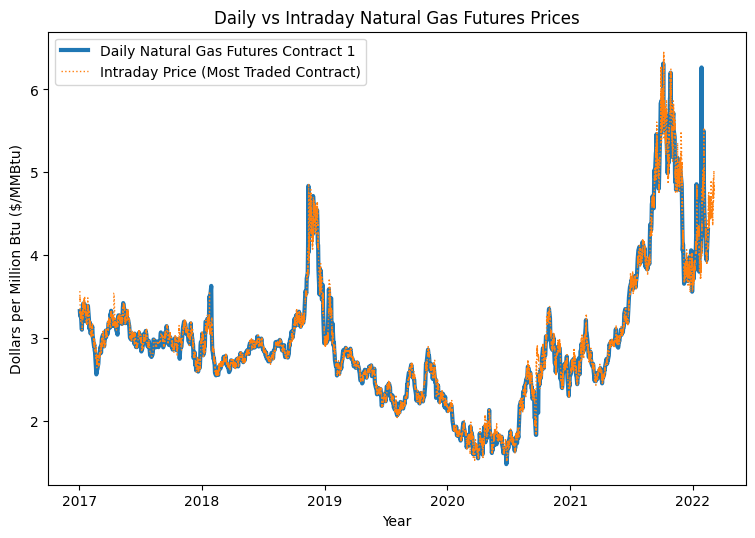

In [17]:
# Set up daily prices
d1 = datetime.datetime.strptime('2017-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
daily_prices = daily_prices[daily_prices['Date'] > d1]

# Plot
figure(figsize=(9, 6), dpi=100)
plt.plot(daily_prices['Date'],daily_prices['Natural Gas Futures Contract 1 (Dollars per Million Btu)'], 
         label='Daily Natural Gas Futures Contract 1', linewidth=3)
plt.plot(clean_intraday['timeUTC'],clean_intraday['midpoint']/1000, ':',
         linewidth=1,label = 'Intraday Price (Most Traded Contract)')
plt.xlabel('Year')
plt.ylabel('Dollars per Million Btu ($/MMBtu)')
plt.title('Daily vs Intraday Natural Gas Futures Prices')
plt.legend()
plt.show()

## Construct graph of Average Actual Forecast Error vs Forecast Window

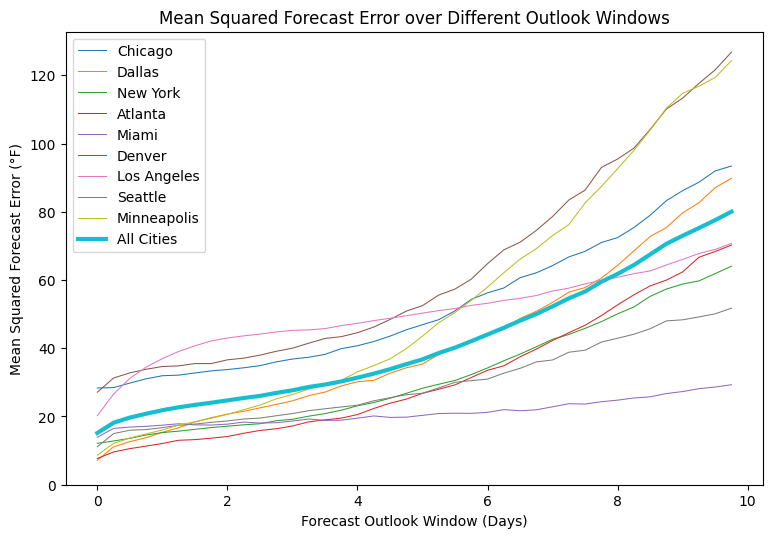

In [1727]:
figure(figsize=(9, 6), dpi=100)

quart_Chicago_df['Chicago Squared Act Forecast Error'] = quart_Chicago_df['Chicago Act Forecast Error']**2
Chicago_act_mean_err = quart_Chicago_df.groupby('forecast window')['Chicago Squared Act Forecast Error'].mean()
plt.plot(sorted(Chicago_act_mean_err.index[0:40] / (60*60*24)),Chicago_act_mean_err[0:40], label = 'Chicago', linewidth=0.75)

quart_Dallas_df['Dallas Squared Act Forecast Error'] = quart_Dallas_df['Dallas Act Forecast Error']**2
Dallas_act_mean_err = quart_Dallas_df.groupby('forecast window')['Dallas Squared Act Forecast Error'].mean()
plt.plot(sorted(Dallas_act_mean_err.index[0:40] / (60*60*24)),Dallas_act_mean_err[0:40], label = 'Dallas', linewidth=0.75)

quart_New_York_df['New York Squared Act Forecast Error'] = quart_New_York_df['New York Act Forecast Error']**2
New_York_act_mean_err = quart_New_York_df.groupby('forecast window')['New York Squared Act Forecast Error'].mean()
plt.plot(sorted(New_York_act_mean_err.index[0:40] / (60*60*24)),New_York_act_mean_err[0:40], label = 'New York', linewidth=0.75)

quart_Atlanta_df['Atlanta Squared Act Forecast Error'] = quart_Atlanta_df['Atlanta Act Forecast Error']**2
Atlanta_act_mean_err = quart_Atlanta_df.groupby('forecast window')['Atlanta Squared Act Forecast Error'].mean()
plt.plot(sorted(Atlanta_act_mean_err.index[0:40] / (60*60*24)),Atlanta_act_mean_err[0:40], label = 'Atlanta', linewidth=0.75)

quart_Miami_df['Miami Squared Act Forecast Error'] = quart_Miami_df['Miami Act Forecast Error']**2
Miami_act_mean_err = quart_Miami_df.groupby('forecast window')['Miami Squared Act Forecast Error'].mean()
plt.plot(sorted(Miami_act_mean_err.index[0:40] / (60*60*24)),Miami_act_mean_err[0:40], label = 'Miami', linewidth=0.75)

quart_Denver_df['Denver Squared Act Forecast Error'] = quart_Denver_df['Denver Act Forecast Error']**2
Denver_act_mean_err = quart_Denver_df.groupby('forecast window')['Denver Squared Act Forecast Error'].mean()
plt.plot(sorted(Denver_act_mean_err.index[0:40] / (60*60*24)),Denver_act_mean_err[0:40], label = 'Denver', linewidth=0.75)

quart_Los_Angeles_df['Los Angeles Squared Act Forecast Error'] = quart_Los_Angeles_df['Los Angeles Act Forecast Error']**2
Los_Angeles_act_mean_err = quart_Los_Angeles_df.groupby('forecast window')['Los Angeles Squared Act Forecast Error'].mean()
plt.plot(sorted(Los_Angeles_act_mean_err.index[0:40] / (60*60*24)),Los_Angeles_act_mean_err[0:40], label = 'Los Angeles',  linewidth=0.75)

quart_Seattle_df['Seattle Squared Act Forecast Error'] = quart_Seattle_df['Seattle Act Forecast Error']**2
Seattle_act_mean_err = quart_Seattle_df.groupby('forecast window')['Seattle Squared Act Forecast Error'].mean()
plt.plot(sorted(Seattle_act_mean_err.index[0:40] / (60*60*24)),Seattle_act_mean_err[0:40], label = 'Seattle',  linewidth=0.75)

quart_Minneapolis_df['Minneapolis Squared Act Forecast Error'] = quart_Minneapolis_df['Minneapolis Act Forecast Error']**2
Minneapolis_act_mean_err = quart_Minneapolis_df.groupby('forecast window')['Minneapolis Squared Act Forecast Error'].mean()
plt.plot(sorted(Minneapolis_act_mean_err.index[0:40] / (60*60*24)),Minneapolis_act_mean_err[0:40], label = 'Minneapolis',  linewidth=0.75)

total_act_mean_err = (Chicago_act_mean_err + Dallas_act_mean_err + New_York_act_mean_err + Atlanta_act_mean_err + Miami_act_mean_err +
                  Denver_act_mean_err  + Los_Angeles_act_mean_err + Seattle_act_mean_err + Minneapolis_act_mean_err) / 9
plt.plot(sorted(total_act_mean_err.index[0:40] / (60*60*24)),total_act_mean_err[0:40], label = 'All Cities',  linewidth=3)


plt.ylabel('Mean Squared Forecast Error (\N{DEGREE SIGN}F)')
plt.xlabel('Forecast Outlook Window (Days)')
plt.title('Mean Squared Forecast Error over Different Outlook Windows')
plt.ylim(bottom=0)
plt.legend()
plt.show()

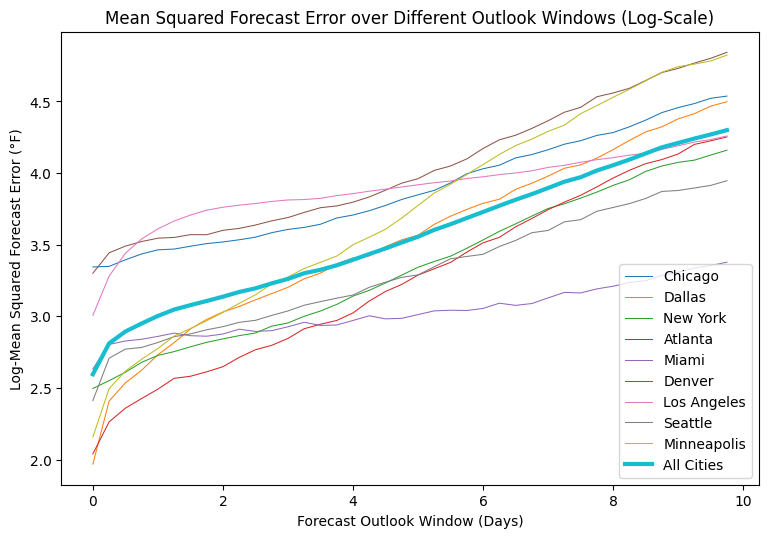

In [1734]:
figure(figsize=(9, 6), dpi=100)

quart_Chicago_df['Chicago Squared Act Forecast Error'] = quart_Chicago_df['Chicago Act Forecast Error']**2
Chicago_act_mean_err = quart_Chicago_df.groupby('forecast window')['Chicago Squared Act Forecast Error'].mean()
plt.plot(sorted(Chicago_act_mean_err.index[0:40] / (60*60*24)),np.log(Chicago_act_mean_err[0:40]), label = 'Chicago', linewidth=0.75)

quart_Dallas_df['Dallas Squared Act Forecast Error'] = quart_Dallas_df['Dallas Act Forecast Error']**2
Dallas_act_mean_err = quart_Dallas_df.groupby('forecast window')['Dallas Squared Act Forecast Error'].mean()
plt.plot(sorted(Dallas_act_mean_err.index[0:40] / (60*60*24)),np.log(Dallas_act_mean_err[0:40]), label = 'Dallas', linewidth=0.75)

quart_New_York_df['New York Squared Act Forecast Error'] = quart_New_York_df['New York Act Forecast Error']**2
New_York_act_mean_err = quart_New_York_df.groupby('forecast window')['New York Squared Act Forecast Error'].mean()
plt.plot(sorted(New_York_act_mean_err.index[0:40] / (60*60*24)),np.log(New_York_act_mean_err[0:40]), label = 'New York', linewidth=0.75)

quart_Atlanta_df['Atlanta Squared Act Forecast Error'] = quart_Atlanta_df['Atlanta Act Forecast Error']**2
Atlanta_act_mean_err = quart_Atlanta_df.groupby('forecast window')['Atlanta Squared Act Forecast Error'].mean()
plt.plot(sorted(Atlanta_act_mean_err.index[0:40] / (60*60*24)),np.log(Atlanta_act_mean_err[0:40]), label = 'Atlanta', linewidth=0.75)

quart_Miami_df['Miami Squared Act Forecast Error'] = quart_Miami_df['Miami Act Forecast Error']**2
Miami_act_mean_err = quart_Miami_df.groupby('forecast window')['Miami Squared Act Forecast Error'].mean()
plt.plot(sorted(Miami_act_mean_err.index[0:40] / (60*60*24)),np.log(Miami_act_mean_err[0:40]), label = 'Miami', linewidth=0.75)

quart_Denver_df['Denver Squared Act Forecast Error'] = quart_Denver_df['Denver Act Forecast Error']**2
Denver_act_mean_err = quart_Denver_df.groupby('forecast window')['Denver Squared Act Forecast Error'].mean()
plt.plot(sorted(Denver_act_mean_err.index[0:40] / (60*60*24)),np.log(Denver_act_mean_err[0:40]), label = 'Denver', linewidth=0.75)

quart_Los_Angeles_df['Los Angeles Squared Act Forecast Error'] = quart_Los_Angeles_df['Los Angeles Act Forecast Error']**2
Los_Angeles_act_mean_err = quart_Los_Angeles_df.groupby('forecast window')['Los Angeles Squared Act Forecast Error'].mean()
plt.plot(sorted(Los_Angeles_act_mean_err.index[0:40] / (60*60*24)),np.log(Los_Angeles_act_mean_err[0:40]), label = 'Los Angeles',  linewidth=0.75)

quart_Seattle_df['Seattle Squared Act Forecast Error'] = quart_Seattle_df['Seattle Act Forecast Error']**2
Seattle_act_mean_err = quart_Seattle_df.groupby('forecast window')['Seattle Squared Act Forecast Error'].mean()
plt.plot(sorted(Seattle_act_mean_err.index[0:40] / (60*60*24)),np.log(Seattle_act_mean_err[0:40]), label = 'Seattle',  linewidth=0.75)

quart_Minneapolis_df['Minneapolis Squared Act Forecast Error'] = quart_Minneapolis_df['Minneapolis Act Forecast Error']**2
Minneapolis_act_mean_err = quart_Minneapolis_df.groupby('forecast window')['Minneapolis Squared Act Forecast Error'].mean()
plt.plot(sorted(Minneapolis_act_mean_err.index[0:40] / (60*60*24)),np.log(Minneapolis_act_mean_err[0:40]), label = 'Minneapolis',  linewidth=0.75)

total_act_mean_err = (np.log(Chicago_act_mean_err) + np.log(Dallas_act_mean_err) + np.log(New_York_act_mean_err) + 
                      np.log(Atlanta_act_mean_err) + np.log(Miami_act_mean_err) + np.log(Denver_act_mean_err)  + 
                      np.log(Los_Angeles_act_mean_err) + np.log(Seattle_act_mean_err) + np.log(Minneapolis_act_mean_err)) / 9
plt.plot(sorted(total_act_mean_err.index[0:40] / (60*60*24)),total_act_mean_err[0:40], label = 'All Cities',  linewidth=3)


plt.ylabel('Log-Mean Squared Forecast Error (\N{DEGREE SIGN}F)')
plt.xlabel('Forecast Outlook Window (Days)')
plt.title('Mean Squared Forecast Error over Different Outlook Windows (Log-Scale)')

plt.legend()
plt.show()

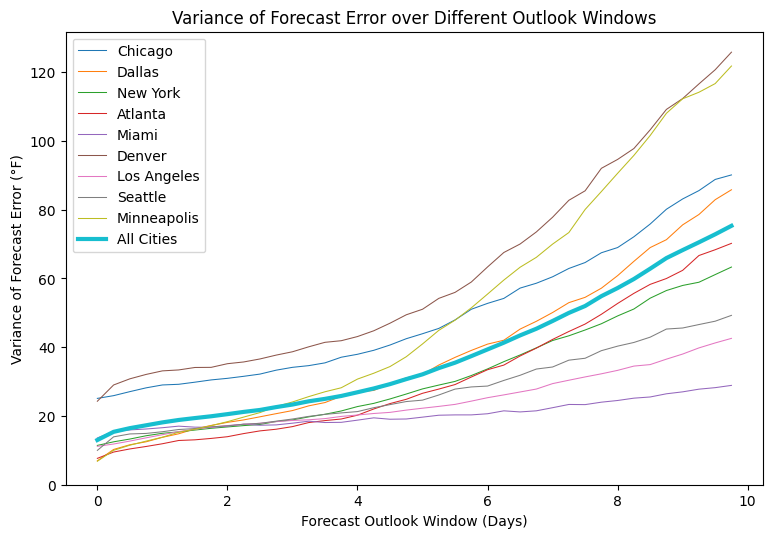

In [1728]:
figure(figsize=(9, 6), dpi=100)

Chicago_act_var_err = quart_Chicago_df.groupby('forecast window')['Chicago Act Forecast Error'].var()
plt.plot(sorted(Chicago_act_var_err.index[0:40] / (60*60*24)),Chicago_act_var_err[0:40], label = 'Chicago',linewidth=0.75)

Dallas_act_var_err = quart_Dallas_df.groupby('forecast window')['Dallas Act Forecast Error'].var()
plt.plot(sorted(Dallas_act_var_err.index[0:40] / (60*60*24)),Dallas_act_var_err[0:40], label = 'Dallas',linewidth=0.75)

New_York_act_var_err = quart_New_York_df.groupby('forecast window')['New York Act Forecast Error'].var()
plt.plot(sorted(New_York_act_var_err.index[0:40] / (60*60*24)),New_York_act_var_err[0:40], label = 'New York',linewidth=0.75)

Atlanta_act_var_err = quart_Atlanta_df.groupby('forecast window')['Atlanta Act Forecast Error'].var()
plt.plot(sorted(Atlanta_act_var_err.index[0:40] / (60*60*24)),Atlanta_act_var_err[0:40], label = 'Atlanta',linewidth=0.75)

Miami_act_var_err = quart_Miami_df.groupby('forecast window')['Miami Act Forecast Error'].var()
plt.plot(sorted(Miami_act_var_err.index[0:40] / (60*60*24)),Miami_act_var_err[0:40], label = 'Miami',linewidth=0.75)

Denver_act_var_err = quart_Denver_df.groupby('forecast window')['Denver Act Forecast Error'].var()
plt.plot(sorted(Denver_act_var_err.index[0:40] / (60*60*24)),Denver_act_var_err[0:40], label = 'Denver',linewidth=0.75)

Los_Angeles_act_var_err = quart_Los_Angeles_df.groupby('forecast window')['Los Angeles Act Forecast Error'].var()
plt.plot(sorted(Los_Angeles_act_var_err.index[0:40] / (60*60*24)),Los_Angeles_act_var_err[0:40], label = 'Los Angeles',linewidth=0.75)

Seattle_act_var_err = quart_Seattle_df.groupby('forecast window')['Seattle Act Forecast Error'].var()
plt.plot(sorted(Seattle_act_var_err.index[0:40] / (60*60*24)),Seattle_act_var_err[0:40], label = 'Seattle',linewidth=0.75)

Minneapolis_act_var_err = quart_Minneapolis_df.groupby('forecast window')['Minneapolis Act Forecast Error'].var()
plt.plot(sorted(Minneapolis_act_var_err.index[0:40] / (60*60*24)),Minneapolis_act_var_err[0:40], label = 'Minneapolis',linewidth=0.75)

total_act_var_err = (Chicago_act_var_err + Dallas_act_var_err + New_York_act_var_err + Atlanta_act_var_err + Miami_act_var_err +
                  Denver_act_var_err  + Los_Angeles_act_var_err + Seattle_act_var_err + Minneapolis_act_var_err) / 9
plt.plot(sorted(total_act_var_err.index[0:40] / (60*60*24)),total_act_var_err[0:40], label = 'All Cities',linewidth=3)


plt.ylabel('Variance of Forecast Error (\N{DEGREE SIGN}F)')
plt.xlabel('Forecast Outlook Window (Days)')
plt.title('Variance of Forecast Error over Different Outlook Windows')
plt.ylim(bottom=0)
plt.legend()
plt.show()

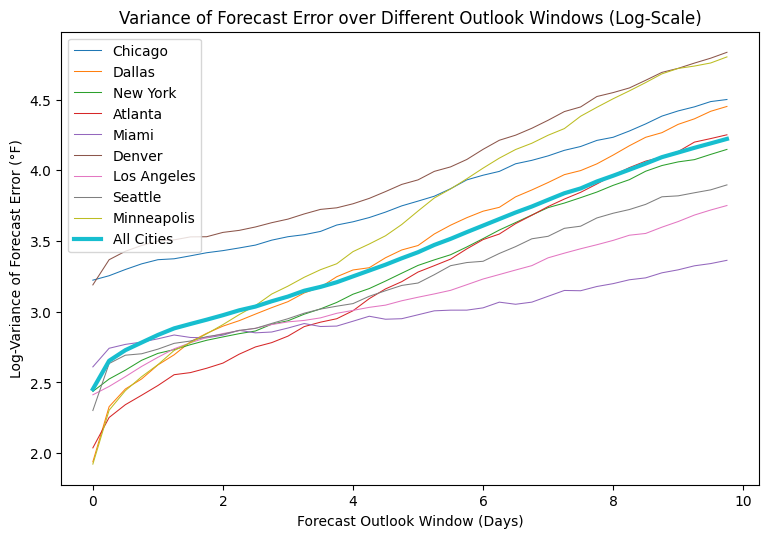

In [2674]:
figure(figsize=(9, 6), dpi=100)

Chicago_act_var_err = quart_Chicago_df.groupby('forecast window')['Chicago Act Forecast Error'].var()
plt.plot(sorted(Chicago_act_var_err.index[0:40] / (60*60*24)), np.log(Chicago_act_var_err[0:40]), label = 'Chicago',linewidth=0.75)

Dallas_act_var_err = quart_Dallas_df.groupby('forecast window')['Dallas Act Forecast Error'].var()
plt.plot(sorted(Dallas_act_var_err.index[0:40] / (60*60*24)),np.log(Dallas_act_var_err[0:40]), label = 'Dallas',linewidth=0.75)

New_York_act_var_err = quart_New_York_df.groupby('forecast window')['New York Act Forecast Error'].var()
plt.plot(sorted(New_York_act_var_err.index[0:40] / (60*60*24)),np.log(New_York_act_var_err[0:40]), label = 'New York',linewidth=0.75)

Atlanta_act_var_err = quart_Atlanta_df.groupby('forecast window')['Atlanta Act Forecast Error'].var()
plt.plot(sorted(Atlanta_act_var_err.index[0:40] / (60*60*24)),np.log(Atlanta_act_var_err[0:40]), label = 'Atlanta',linewidth=0.75)

Miami_act_var_err = quart_Miami_df.groupby('forecast window')['Miami Act Forecast Error'].var()
plt.plot(sorted(Miami_act_var_err.index[0:40] / (60*60*24)),np.log(Miami_act_var_err[0:40]), label = 'Miami',linewidth=0.75)

Denver_act_var_err = quart_Denver_df.groupby('forecast window')['Denver Act Forecast Error'].var()
plt.plot(sorted(Denver_act_var_err.index[0:40] / (60*60*24)),np.log(Denver_act_var_err[0:40]), label = 'Denver',linewidth=0.75)

Los_Angeles_act_var_err = quart_Los_Angeles_df.groupby('forecast window')['Los Angeles Act Forecast Error'].var()
plt.plot(sorted(Los_Angeles_act_var_err.index[0:40] / (60*60*24)),np.log(Los_Angeles_act_var_err[0:40]), label = 'Los Angeles',linewidth=0.75)

Seattle_act_var_err = quart_Seattle_df.groupby('forecast window')['Seattle Act Forecast Error'].var()
plt.plot(sorted(Seattle_act_var_err.index[0:40] / (60*60*24)),np.log(Seattle_act_var_err[0:40]), label = 'Seattle',linewidth=0.75)

Minneapolis_act_var_err = quart_Minneapolis_df.groupby('forecast window')['Minneapolis Act Forecast Error'].var()
plt.plot(sorted(Minneapolis_act_var_err.index[0:40] / (60*60*24)),np.log(Minneapolis_act_var_err[0:40]), label = 'Minneapolis',linewidth=0.75)

total_act_var_err = (np.log(Chicago_act_var_err) + np.log(Dallas_act_var_err) + np.log(New_York_act_var_err)
                     + np.log(Atlanta_act_var_err) + np.log(Miami_act_var_err) + np.log(Denver_act_var_err)
                     + np.log(Los_Angeles_act_var_err) + np.log(Seattle_act_var_err) + np.log(Minneapolis_act_var_err)) / 9
plt.plot(sorted(total_act_var_err.index[0:40] / (60*60*24)),total_act_var_err[0:40], label = 'All Cities',linewidth=3)


plt.ylabel('Log-Variance of Forecast Error (\N{DEGREE SIGN}F)')
plt.xlabel('Forecast Outlook Window (Days)')
plt.title('Variance of Forecast Error over Different Outlook Windows (Log-Scale)')
plt.legend()
plt.show()

## Daily Trade Volume (EST, No Thursday)

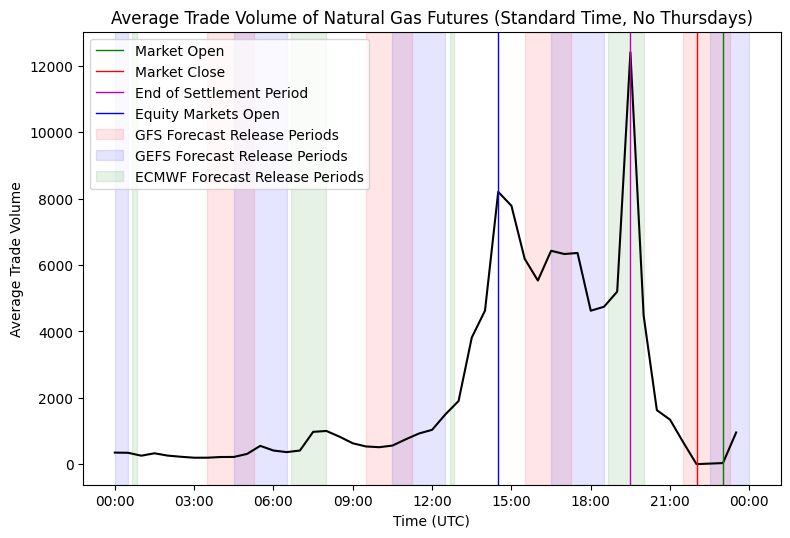

In [1826]:
# Calculate average number of trades per time of day

est_intraday = clean_intraday[clean_intraday['timeUTC'] == clean_intraday['timeNY'] + datetime.timedelta(hours=5)]
est_intraday = est_intraday[est_intraday['timeUTC'].dt.weekday != 3]
est_intraday = est_intraday.fillna(0)
avg_trades = est_intraday.groupby('time')['v'].mean()
x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in avg_trades.index]

figure(figsize=(9, 6), dpi=100)
plt.plot(x_dt,avg_trades, color ='black')

# Plot fixed time events
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23)),
            c='g',linewidth=1, label = 'Market Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22)),
            c='r',linewidth=1, label = 'Market Close')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 19, minute = 30)),
            c='m',linewidth=1,label = 'End of Settlement Period')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 14, minute = 30)),
            c='blue',linewidth=1,label = 'Equity Markets Open')

# Plot GFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 3, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 5, minute = 15)),
            alpha=0.1, color='red', label = 'GFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 9, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 11, minute = 15)),
            alpha=0.1, color='red')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 17, minute = 15)),
            alpha=0.1, color='red')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 15)),
            alpha=0.1, color='red')

# Plot GEFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 4, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 30)),
            alpha=0.1, color='blue', label = 'GEFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 10, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 30)),
            alpha=0.1, color='blue')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 16, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            alpha=0.1, color='blue')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 59)),
            alpha=0.1, color='blue')
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 0)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 30)),
            alpha=0.1, color='blue')

# Plot ECMWF Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 8, minute = 0)),
            alpha=0.1, color='green', label = 'ECMWF Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 50)),
            alpha=0.1, color='green')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 20, minute = 0)),
            alpha=0.1, color='green')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 50)),
            alpha=0.1, color='green')


xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time (UTC)')
plt.ylabel('Average Trade Volume')
plt.legend()
plt.title('Average Trade Volume of Natural Gas Futures (Standard Time, No Thursdays)')
plt.show()

## Daily Trade Volume (EDT, No Thursday)

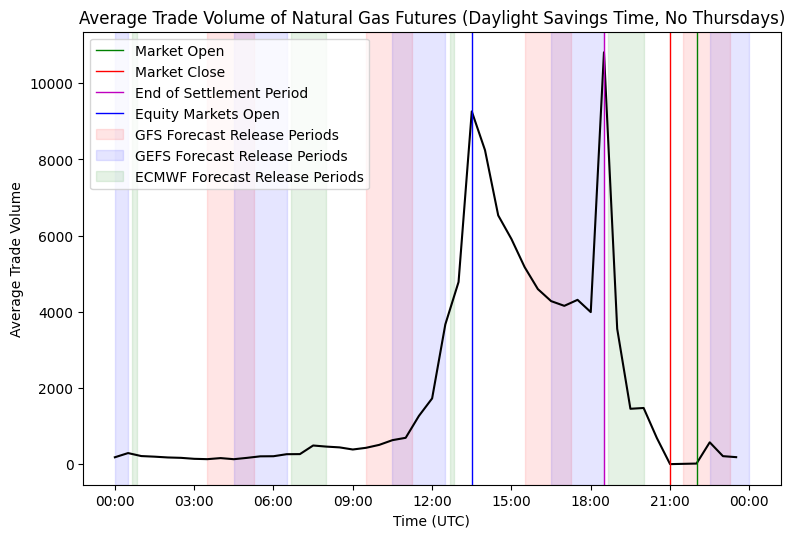

In [1828]:
# Calculate average number of trades per time of day
edt_intraday = clean_intraday[clean_intraday['timeUTC'] == clean_intraday['timeNY'] + datetime.timedelta(hours=4)]
edt_intraday = edt_intraday[edt_intraday['timeUTC'].dt.weekday != 3]
edt_intraday = edt_intraday.fillna(0)
avg_trades = edt_intraday.groupby('time')['v'].mean()
x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in avg_trades.index]

figure(figsize=(9, 6), dpi=100)
plt.plot(x_dt,avg_trades, color='black')

# Plot fixed time events
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22)),
            c='g',linewidth=1, label = 'Market Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21)),
            c='r',linewidth=1, label = 'Market Close')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            c='m',linewidth=1,label = 'End of Settlement Period')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 13, minute = 30)),
            c='blue',linewidth=1,label = 'Equity Markets Open')

# Plot GFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 3, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 5, minute = 15)),
            alpha=0.1, color='red', label = 'GFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 9, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 11, minute = 15)),
            alpha=0.1, color='red')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 17, minute = 15)),
            alpha=0.1, color='red')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 15)),
            alpha=0.1, color='red')

# Plot GEFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 4, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 30)),
            alpha=0.1, color='blue', label = 'GEFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 10, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 30)),
            alpha=0.1, color='blue')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 16, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            alpha=0.1, color='blue')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 59)),
            alpha=0.1, color='blue')
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 0)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 30)),
            alpha=0.1, color='blue')

# Plot ECMWF Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 8, minute = 0)),
            alpha=0.1, color='green', label = 'ECMWF Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 50)),
            alpha=0.1, color='green')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 20, minute = 0)),
            alpha=0.1, color='green')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 50)),
            alpha=0.1, color='green')


xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time (UTC)')
plt.ylabel('Average Trade Volume')
plt.title('Average Trade Volume of Natural Gas Futures (Daylight Savings Time, No Thursdays)')
plt.legend()
plt.show()

## Daily Trade Volume (EST, Only Thursday)

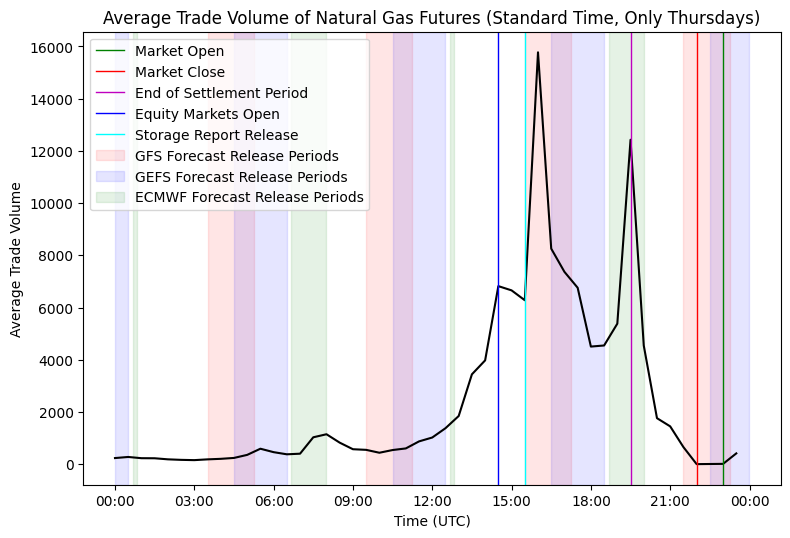

In [2666]:
# Calculate average number of trades per time of day

est_intraday = clean_intraday[clean_intraday['timeUTC'] == clean_intraday['timeNY'] + datetime.timedelta(hours=5)]
est_intraday = est_intraday[est_intraday['timeUTC'].dt.weekday == 3]
est_intraday = est_intraday.fillna(0)
avg_trades = est_intraday.groupby('time')['v'].mean()
x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in avg_trades.index]

figure(figsize=(9, 6), dpi=100)
plt.plot(x_dt,avg_trades, color ='black')

# Plot fixed time events
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23)),
            c='g',linewidth=1, label = 'Market Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22)),
            c='r',linewidth=1, label = 'Market Close')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 19, minute = 30)),
            c='m',linewidth=1,label = 'End of Settlement Period')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 14, minute = 30)),
            c='blue',linewidth=1,label = 'Equity Markets Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            c='cyan',linewidth=1,label = 'Storage Report Release')

# Plot GFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 3, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 5, minute = 15)),
            alpha=0.1, color='red', label = 'GFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 9, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 11, minute = 15)),
            alpha=0.1, color='red')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 17, minute = 15)),
            alpha=0.1, color='red')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 15)),
            alpha=0.1, color='red')

# Plot GEFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 4, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 30)),
            alpha=0.1, color='blue', label = 'GEFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 10, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 30)),
            alpha=0.1, color='blue')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 16, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            alpha=0.1, color='blue')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 59)),
            alpha=0.1, color='blue')
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 0)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 30)),
            alpha=0.1, color='blue')

# Plot ECMWF Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 8, minute = 0)),
            alpha=0.1, color='green', label = 'ECMWF Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 50)),
            alpha=0.1, color='green')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 20, minute = 0)),
            alpha=0.1, color='green')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 50)),
            alpha=0.1, color='green')


xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time (UTC)')
plt.ylabel('Average Trade Volume')
plt.legend()
plt.title('Average Trade Volume of Natural Gas Futures (Standard Time, Only Thursdays)')
plt.show()

## Daily Trade Volume (EDT, Only Thursday)

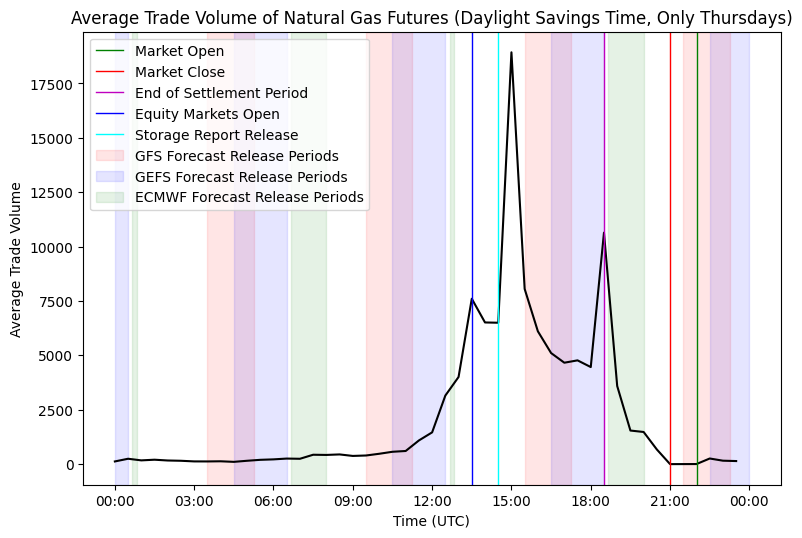

In [2664]:
# Calculate average number of trades per time of day
edt_intraday = clean_intraday[clean_intraday['timeUTC'] == clean_intraday['timeNY'] + datetime.timedelta(hours=4)]
edt_intraday = edt_intraday[edt_intraday['timeUTC'].dt.weekday == 3]
edt_intraday = edt_intraday.fillna(0)
avg_trades = edt_intraday.groupby('time')['v'].mean()
x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in avg_trades.index]

figure(figsize=(9, 6), dpi=100)
plt.plot(x_dt,avg_trades, color='black')

# Plot fixed time events
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22)),
            c='g',linewidth=1, label = 'Market Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21)),
            c='r',linewidth=1, label = 'Market Close')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            c='m',linewidth=1,label = 'End of Settlement Period')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 13, minute = 30)),
            c='blue',linewidth=1,label = 'Equity Markets Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 14, minute = 30)),
            c='cyan',linewidth=1,label = 'Storage Report Release')

# Plot GFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 3, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 5, minute = 15)),
            alpha=0.1, color='red', label = 'GFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 9, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 11, minute = 15)),
            alpha=0.1, color='red')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 17, minute = 15)),
            alpha=0.1, color='red')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 15)),
            alpha=0.1, color='red')

# Plot GEFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 4, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 30)),
            alpha=0.1, color='blue', label = 'GEFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 10, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 30)),
            alpha=0.1, color='blue')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 16, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            alpha=0.1, color='blue')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 59)),
            alpha=0.1, color='blue')
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 0)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 30)),
            alpha=0.1, color='blue')

# Plot ECMWF Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 8, minute = 0)),
            alpha=0.1, color='green', label = 'ECMWF Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 50)),
            alpha=0.1, color='green')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 20, minute = 0)),
            alpha=0.1, color='green')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 50)),
            alpha=0.1, color='green')


xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time (UTC)')
plt.ylabel('Average Trade Volume')
plt.title('Average Trade Volume of Natural Gas Futures (Daylight Savings Time, Only Thursdays)')
plt.legend()
plt.show()

## Daily Trade Volume (EST, All Days)

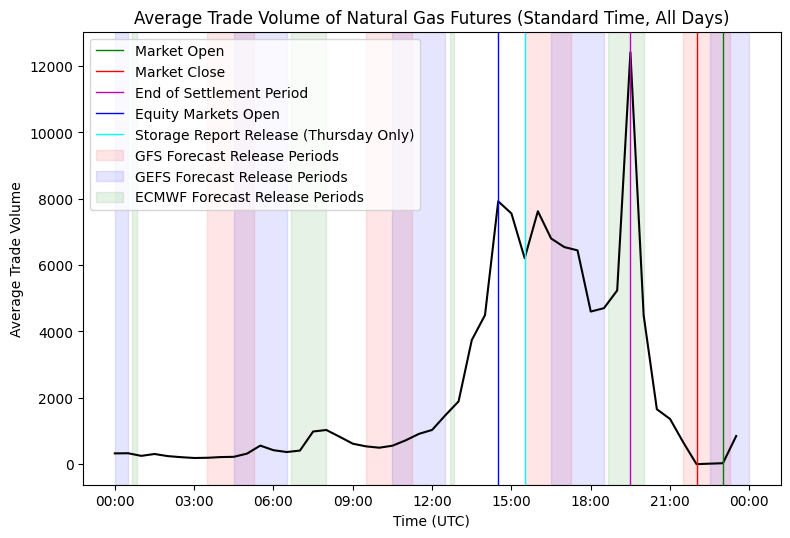

In [2668]:
# Calculate average number of trades per time of day

est_intraday = clean_intraday[clean_intraday['timeUTC'] == clean_intraday['timeNY'] + datetime.timedelta(hours=5)]
est_intraday = est_intraday.fillna(0)
avg_trades = est_intraday.groupby('time')['v'].mean()
x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in avg_trades.index]

figure(figsize=(9, 6), dpi=100)
plt.plot(x_dt,avg_trades, color ='black')

# Plot fixed time events
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23)),
            c='g',linewidth=1, label = 'Market Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22)),
            c='r',linewidth=1, label = 'Market Close')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 19, minute = 30)),
            c='m',linewidth=1,label = 'End of Settlement Period')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 14, minute = 30)),
            c='blue',linewidth=1,label = 'Equity Markets Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            c='cyan',linewidth=1,label = 'Storage Report Release (Thursday Only)')

# Plot GFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 3, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 5, minute = 15)),
            alpha=0.1, color='red', label = 'GFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 9, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 11, minute = 15)),
            alpha=0.1, color='red')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 17, minute = 15)),
            alpha=0.1, color='red')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 15)),
            alpha=0.1, color='red')

# Plot GEFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 4, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 30)),
            alpha=0.1, color='blue', label = 'GEFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 10, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 30)),
            alpha=0.1, color='blue')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 16, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            alpha=0.1, color='blue')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 59)),
            alpha=0.1, color='blue')
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 0)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 30)),
            alpha=0.1, color='blue')

# Plot ECMWF Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 8, minute = 0)),
            alpha=0.1, color='green', label = 'ECMWF Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 50)),
            alpha=0.1, color='green')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 20, minute = 0)),
            alpha=0.1, color='green')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 50)),
            alpha=0.1, color='green')


xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time (UTC)')
plt.ylabel('Average Trade Volume')
plt.legend()
plt.title('Average Trade Volume of Natural Gas Futures (Standard Time, All Days)')
plt.show()

## Daily Trade Volume (EDT, All Days)

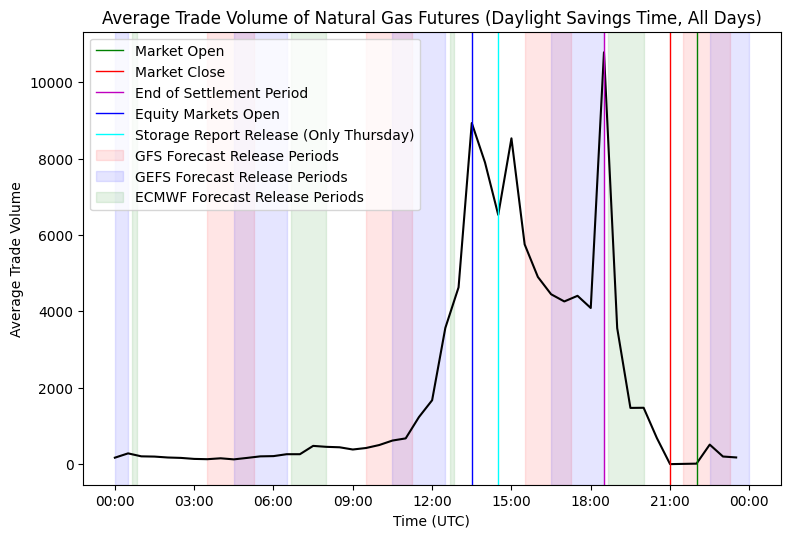

In [2670]:
# Calculate average number of trades per time of day
edt_intraday = clean_intraday[clean_intraday['timeUTC'] == clean_intraday['timeNY'] + datetime.timedelta(hours=4)]
edt_intraday = edt_intraday.fillna(0)
avg_trades = edt_intraday.groupby('time')['v'].mean()
x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in avg_trades.index]

figure(figsize=(9, 6), dpi=100)
plt.plot(x_dt,avg_trades, color='black')

# Plot fixed time events
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22)),
            c='g',linewidth=1, label = 'Market Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21)),
            c='r',linewidth=1, label = 'Market Close')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            c='m',linewidth=1,label = 'End of Settlement Period')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 13, minute = 30)),
            c='blue',linewidth=1,label = 'Equity Markets Open')
plt.axvline(x=datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 14, minute = 30)),
            c='cyan',linewidth=1,label = 'Storage Report Release (Only Thursday)')

# Plot GFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 3, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 5, minute = 15)),
            alpha=0.1, color='red', label = 'GFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 9, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 11, minute = 15)),
            alpha=0.1, color='red')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 15, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 17, minute = 15)),
            alpha=0.1, color='red')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 21, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 15)),
            alpha=0.1, color='red')

# Plot GEFS Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 4, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 30)),
            alpha=0.1, color='blue', label = 'GEFS Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 10, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 30)),
            alpha=0.1, color='blue')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 16, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 30)),
            alpha=0.1, color='blue')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 22, minute = 30)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 23, minute = 59)),
            alpha=0.1, color='blue')
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 0)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 30)),
            alpha=0.1, color='blue')

# Plot ECMWF Release Periods

# 00:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 6, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 8, minute = 0)),
            alpha=0.1, color='green', label = 'ECMWF Forecast Release Periods')

# 06:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 12, minute = 50)),
            alpha=0.1, color='green')

# 12:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 18, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 20, minute = 0)),
            alpha=0.1, color='green')

# 18:00 UTC
plt.axvspan(xmin = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 40)),
            xmax = datetime.datetime.combine(datetime.date.today(), datetime.time(hour = 0, minute = 50)),
            alpha=0.1, color='green')


xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time (UTC)')
plt.ylabel('Average Trade Volume')
plt.title('Average Trade Volume of Natural Gas Futures (Daylight Savings Time, All Days)')
plt.legend()
plt.show()